<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [2]:
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [4]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [5]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [6]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
MEDV    506 non-null float64
dtypes: float64(1)
memory usage: 4.0 KB


In [7]:
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [8]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

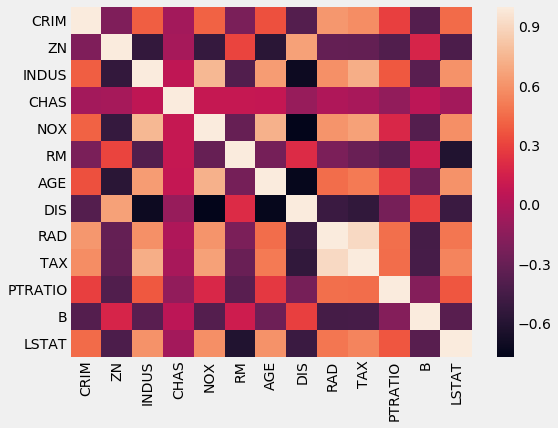

In [9]:
# Before choosing the predictors, plot a heatmap so as to see which features we can choose
import seaborn as sns
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")
sns.heatmap(X.corr())


In [10]:
Xchosen = X[['TAX','INDUS','NOX','AGE']]
Xchosen.head(3)

,TAX,INDUS,NOX,AGE
0,296.0,2.31,0.538,65.2
1,242.0,7.07,0.469,78.9
2,242.0,7.07,0.469,61.1


We can choose features that are not highly correlated. So we choose TAX, INDUS, NOX, AGE

In [11]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Note that in this first exercise we are using the entire dataset to fit.
lr.fit(Xchosen,y)
print('Coefficients: ', lr.coef_)
print('Intercept: ' , lr.intercept_)
lr.score(Xchosen,y)

Coefficients:  [[-0.0128978  -0.32261532 -1.87548047 -0.02770811]]
Intercept:  [34.33146277]


0.2692113856847064

In [12]:
predicted=lr.predict(Xchosen)
pred_df = pd.DataFrame(predicted,columns=['predicted'], index=Xchosen.index)
df = pd.concat([Xchosen,y,pred_df],axis=1) 
df.head()

,TAX,INDUS,NOX,AGE,MEDV,predicted
0,296.0,2.31,0.538,65.2,24.0,26.952896
1,242.0,7.07,0.469,78.9,21.6,25.863535
2,242.0,7.07,0.469,61.1,34.7,26.356740
3,222.0,2.18,0.458,45.8,33.4,28.636849
4,222.0,2.18,0.458,54.2,36.2,28.404101


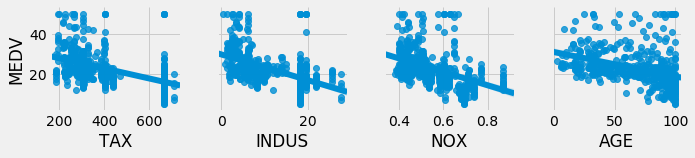

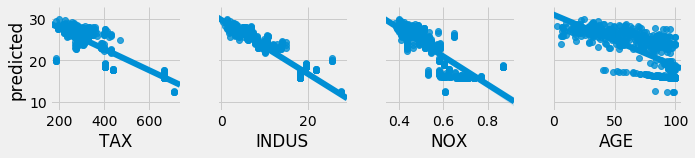

In [13]:
sns.pairplot(df, x_vars=Xchosen.columns, y_vars='MEDV', kind='reg');
sns.pairplot(df, x_vars=Xchosen.columns, y_vars='predicted', kind='reg');
#for i in Xchosen.columns:
#    ax = df.plot(x=i, y='MEDV', color='DarkBlue', label='Actual', kind='scatter')
#    df.plot(x=i,y='predicted', color='DarkGreen', label='Predicted', kind='scatter', ax=ax)

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [14]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics

In [15]:
def plot_actual_vs_predicted(x,y_act,y_pred):
    pred_df = pd.DataFrame(y_pred,columns=['predicted'], index=x.index)
    df = pd.concat([x,y_act,pred_df],axis=1)
    print(df.head())
    sns.pairplot(df, x_vars=x.columns, y_vars='MEDV', kind='reg');
    sns.pairplot(df, x_vars=x.columns, y_vars='predicted', kind='reg');
    #for i in x.columns:
    #    ax = df.plot(x=i, y='MEDV', color='DarkBlue', label='Actual', kind='scatter')
    #    df.plot(x=i,y='predicted', color='DarkGreen', label='Predicted', kind='scatter', ax=ax)

In [16]:
def regress_and_plot(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    print('Coefficients: ', lr.coef_)
    print('Intercept: ' , lr.intercept_)
    print('Score: ', lr.score(X_test,y_test))
    print('Mean Squared Error Value: ', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error Value: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    plot_actual_vs_predicted(X_test,y_test,y_pred)


Coefficients:  [[-0.01540457 -0.3512799  -0.79655471 -0.01887041]]
Intercept:  [34.48772718]
Score:  0.18756495710875332
Mean Squared Error Value:  65.6675741247145
Root Mean Squared Error Value:  8.103553178989726
       TAX  INDUS     NOX    AGE  MEDV  predicted
410  666.0  18.10  0.5970  100.0  15.0  15.507532
85   247.0   4.49  0.4490   56.1  26.6  27.689268
280  216.0   3.33  0.4429   64.5  45.4  28.420642
422  666.0  18.10  0.6140   87.6  20.8  15.727984
199  402.0   1.47  0.4030   15.3  34.9  27.168979


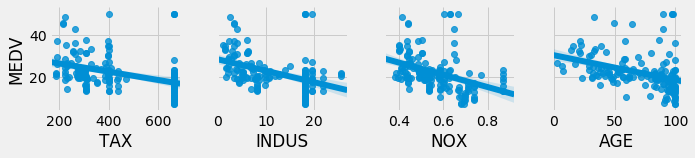

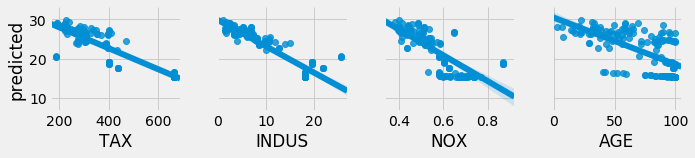

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Xchosen, y, test_size = 0.3, random_state=123)
regress_and_plot(X_train,X_test,y_train,y_test)

Coefficients:  [[-0.01412013 -0.32250641 -2.26909412 -0.02580028]]
Intercept:  [34.67652409]
Score:  -0.03300341064343737
Mean Squared Error Value:  118.1034904316776
Root Mean Squared Error Value:  10.867542980438476
       TAX  INDUS     NOX    AGE  MEDV  predicted
410  666.0  18.10  0.5970  100.0  15.0  15.500476
85   247.0   4.49  0.4490   56.1  26.6  27.274580
280  216.0   3.33  0.4429   64.5  45.4  27.883531
422  666.0  18.10  0.6140   87.6  20.8  15.781825
199  402.0   1.47  0.4030   15.3  34.9  27.216959


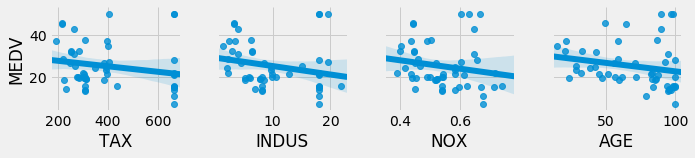

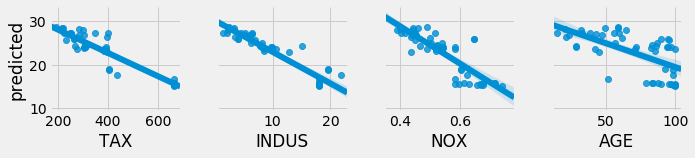

In [18]:
X_train, X_test, y_train, y_test = train_test_split(Xchosen, y, test_size = 0.1, random_state=123)
regress_and_plot(X_train,X_test,y_train,y_test)

As the training size has increased from 70% to 90%, we see the mean squared error value also has increased. This shows that model becomes more "generalized". In other words, the overfitting has reduced.

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [19]:
from sklearn import model_selection
def regress_with_kfold_split(number_of_splits, X, y):
    kf  =  model_selection.KFold(n_splits=number_of_splits)
    mse_values = []
    scores = []
    n = 0
    
    #print("------CROSS VALIDATION with splits ", number_of_splits)
    for train_index, test_index in kf.split(X, y):
        lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
        
        mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
        scores.append(lr.score(X, y))
        
        n += 1
        
        #print('Model {}'.format(n))
        #print('MSE: {}'.format(mse_values[n-1]))
        #print('RMSE: {}'.format(np.sqrt(mse_values[n-1])))
        #print('R2: {}\n'.format(scores[n-1]))
    
    
    #print("~~~~ SUMMARY OF CROSS VALIDATION for split {} ~~~~".format(number_of_splits))
    #print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
    #print('Mean of RMSE for all folds: {}'.format(np.mean(np.sqrt(mse_values))))
    #print('Mean of R2 for all folds: {}'.format(np.mean(scores)))
    return np.mean(np.sqrt(mse_values)), np.mean(scores)


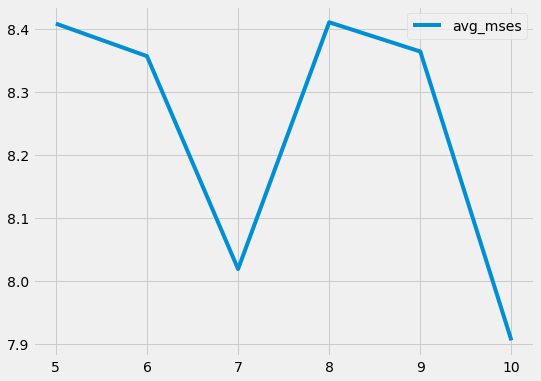

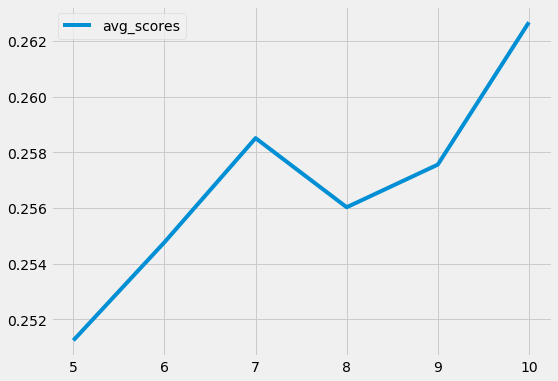

In [20]:
avg_mses = []
avg_scores = []
folds = []
for i in range(5,11,1):
    folds.append(i)
    mse, scr = regress_with_kfold_split(i,Xchosen,y)
    avg_mses.append(mse)
    avg_scores.append(scr)
    
#print (avg_mses)    
# Plot the average Mean Square Error values for different folds
pd.DataFrame(avg_mses, index=folds, columns=['avg_mses']).plot()
# Plot the average score values for different folds
pd.DataFrame(avg_scores, index=folds, columns=['avg_scores']).plot()

    


We see as the number of folds increases, the variance (identifiied by MSEs) decrease first and then increase.

Based on above, we can say at 10 folds, the variance is the lowest.

As the number of folds increase, the number of observations available for training set decreases. Hence outliers might have negative impact on the modell 

# KNN Practice

In [21]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

HTTPError: HTTP Error 407: Proxy Authentication Required

In [ ]:
iris.head()

In [ ]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [ ]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
species_map_dict = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
iris['species_num'] = iris['species'].map(lambda x: species_map_dict[x])
iris.head()                    

species_color_map_dict = {'Iris-setosa':'red', 'Iris-versicolor':'green', 'Iris-virginica':'blue'}
iris['species_color_code'] = iris['species'].map(lambda x: species_color_map_dict[x])
iris.head()
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='petal_length', y='petal_width', c=iris['species_color_code'])

# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c=iris['species_color_code'])


## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [ ]:
X = iris.drop(['species','species_num','species_color_code'], axis=1)
X.head()

### Create your target vector "y"
This will be the species type.

In [ ]:
y=iris['species_num']
y.head()

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(1)

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [ ]:

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print ('Predicted: ', y_pred)
print ('Actual: ', y_test.values)
metrics.accuracy_score(y_test.values, y_pred)

### Create a Model With Five Neighbors. Did it Improve?

In [ ]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print ('Predicted: ', y_pred)
print ('Actual: ', y_test.values)
metrics.accuracy_score(y_test.values, y_pred)

Yes the accuracy has improved from 0.8947 to 0.9737

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [ ]:
accuracies = []
for i in range(1,len(X_train)+1):
    accuracies.append(metrics.accuracy_score(y_test.values,KNeighborsClassifier(i).fit(X_train,y_train).predict(X_test)))
pd.DataFrame(accuracies).plot()  

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [ ]:
X_train.head()

In [ ]:
X_train.columns

In [ ]:
X_new = pd.DataFrame({'sepal_length':5.4, 'sepal_width':2.7, 'petal_length':3.5, 'petal_width':0.2}, index=[0])
X_new

In [ ]:
knn.predict_proba(X_new)

knn.predict_proba gives a probability of assigning each of the classification for the given new observation.
In the above example, it gives a probability of 
0 for the observation to be classified as Iris-setosa, 
1 for the observation to be classified as Iris-versicolor
0 for the observation to be cclassifed as Iris-virginica

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [22]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [23]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          1.59e-321
Time:                        16:44:33   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [24]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [25]:
#features = [x for x in df.columns.values if x != 'MEDV']
#features
Xchosen = df[['TAX','INDUS','NOX','AGE']]
y= df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(Xchosen, y, random_state=123)

model = smf.ols(formula='MEDV ~ TAX + INDUS + NOX + AGE', data= pd.concat([X_train,y_train], axis=1))
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     37.60
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           1.93e-26
Time:                        16:44:43   Log-Likelihood:                -1318.3
No. Observations:                 379   AIC:                             2647.
Df Residuals:                     374   BIC:                             2666.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.1791      2.382     14.771      0.000      30.496      39.862
TAX           -0.0138      0.004     -3.737      0.000      -0.021      -0.007
INDUS         -0.3328      0.104     -3.208      0.001      -0.537      -0.129
NOX           -4.0891      6.389     -0.640      0.523     -16.653       8.475
AGE           -0.0166      0.022     -0.768      0.443      -0.059       0.026
==============================================================================
Omnibus:                      153.903   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.275
Skew:                           1.856   Prob(JB):                    1.17e-115
Kurtosis:                       7.443   Cond. No.                     7.37e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

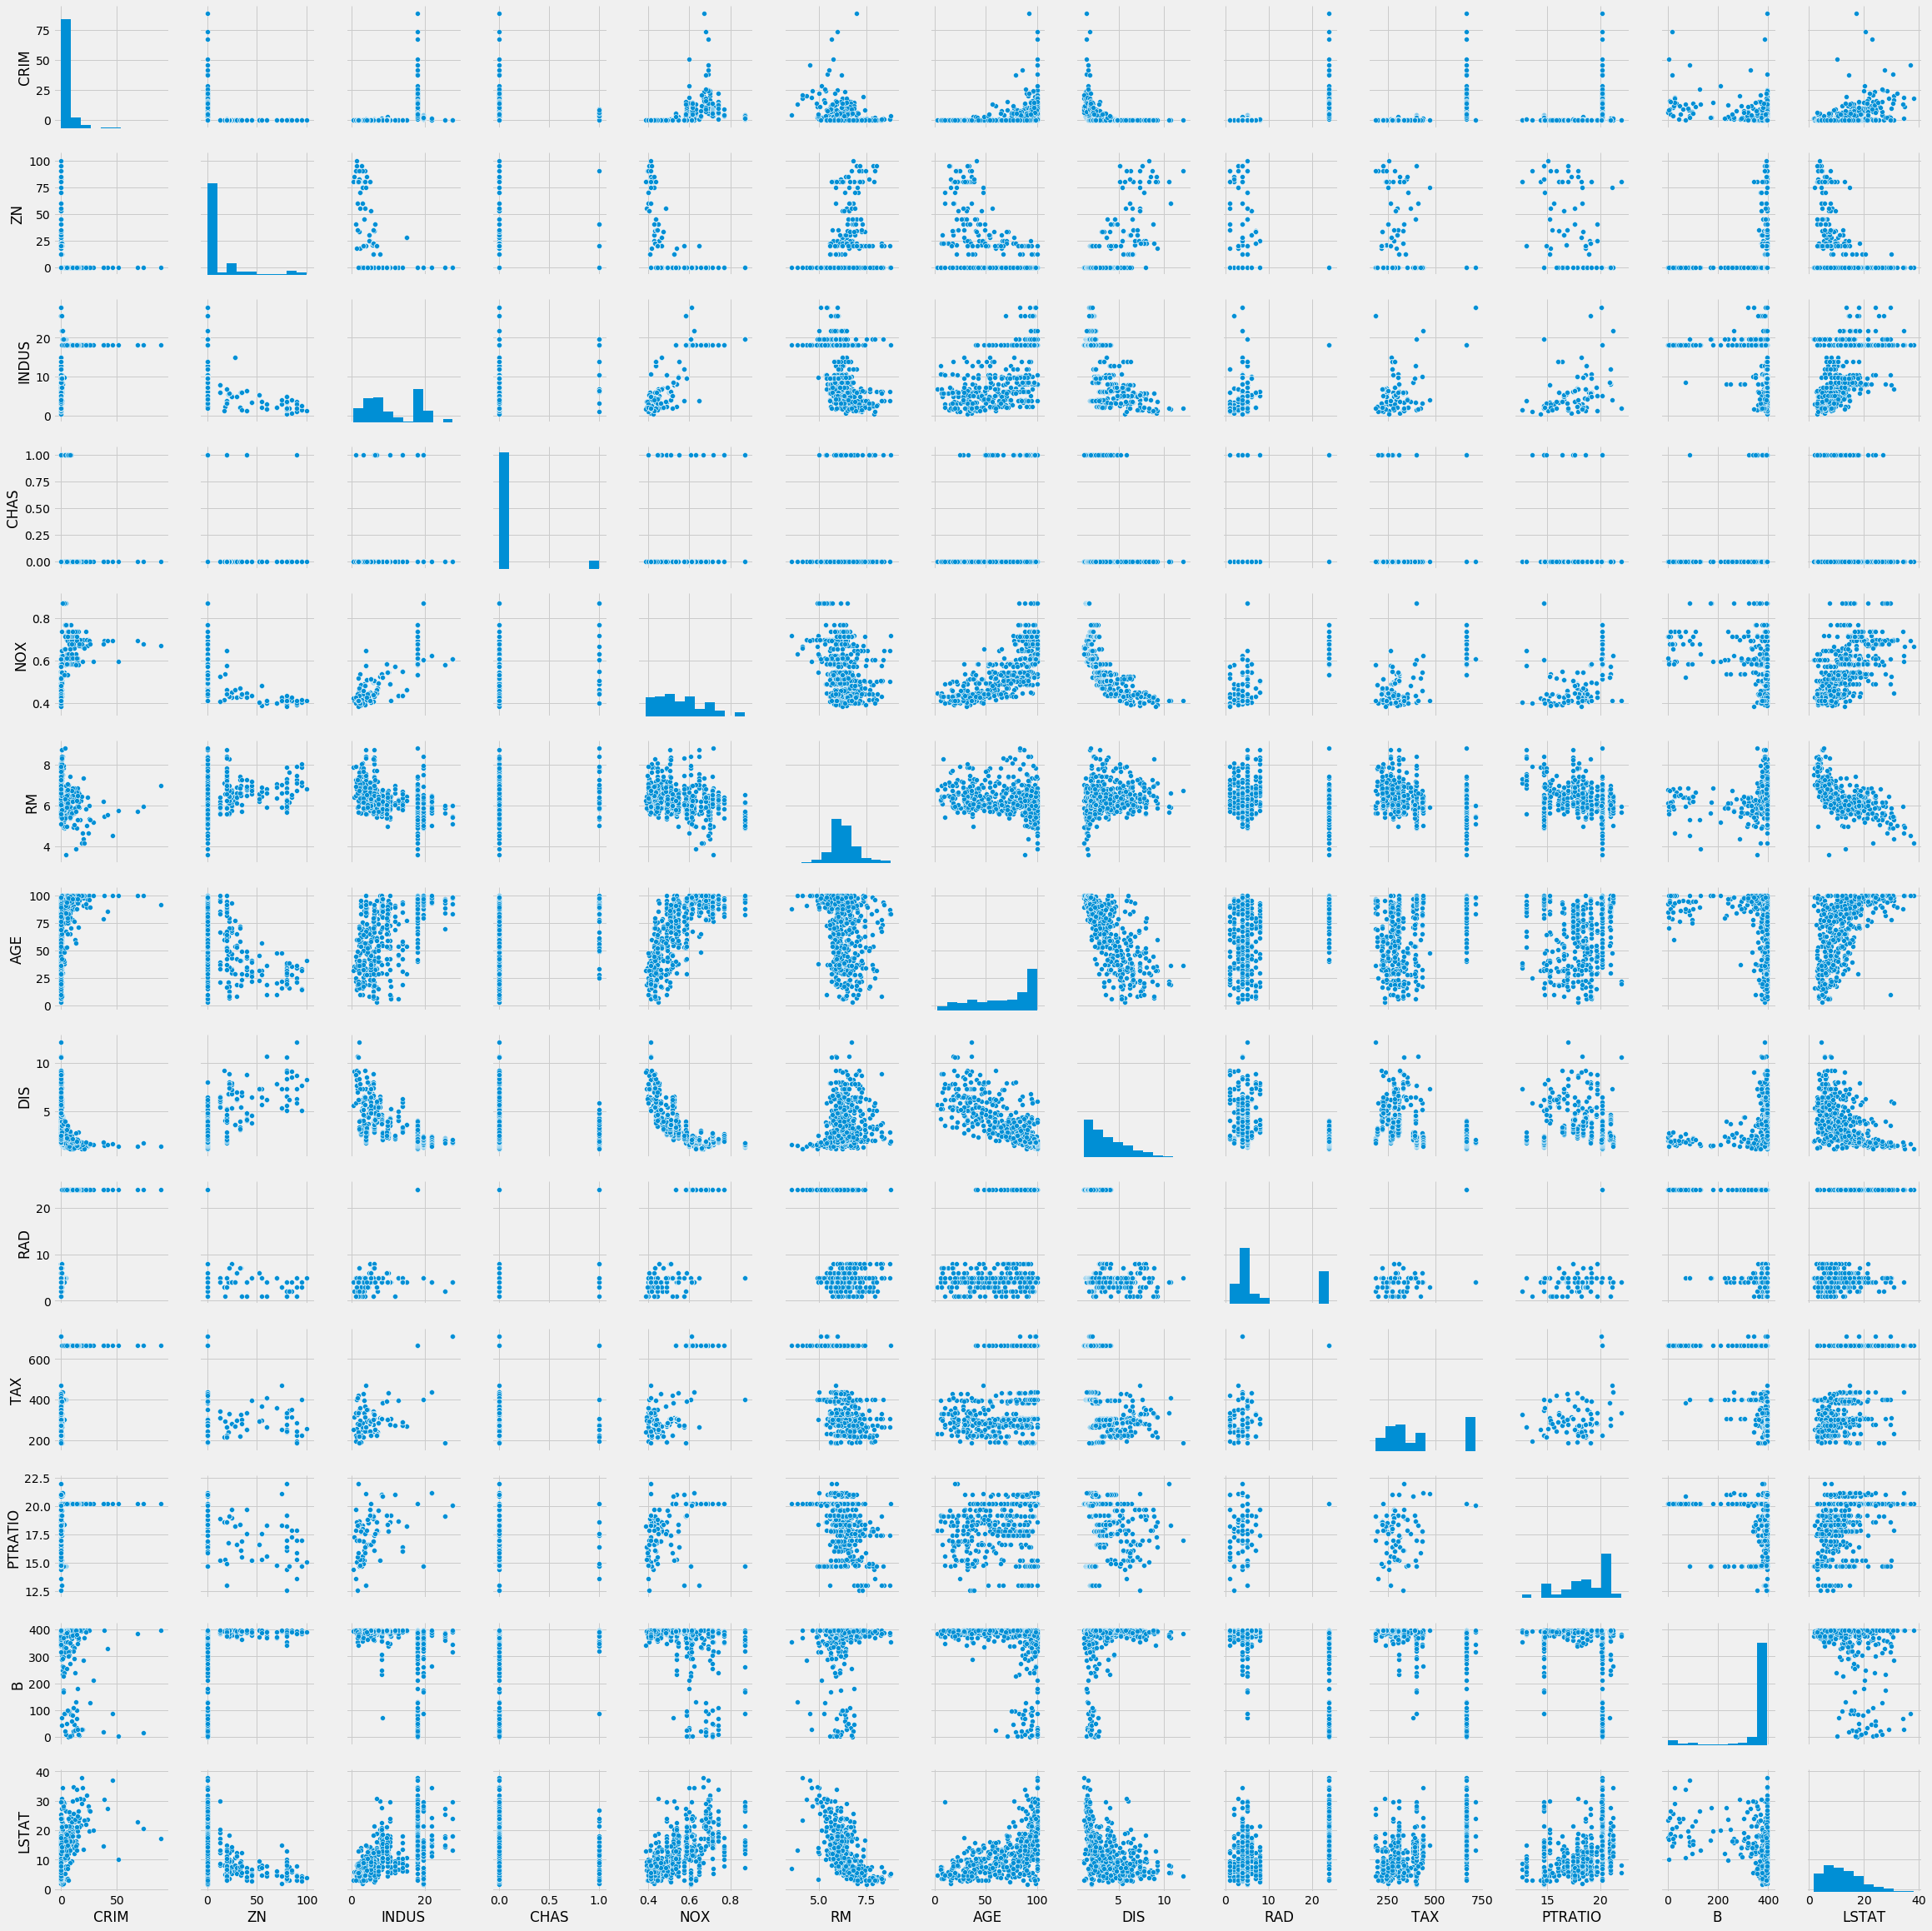

In [26]:
# Check out variable relations
import seaborn as sns

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
sns.pairplot(X);

In [69]:
# Check out Pearson scores
import scipy.stats as ss
col1 = []
col2 = []
pearson_coeffs = []
predictors = [i for i in df.columns if i != 'MEDV']
for i in range(len(predictors)):
    for j in range(i,len(predictors)):
        pred1 = df.iloc[:,i:i+1]
        pred2 = df.iloc[:,j:j+1]
        pc, pv = ss.pearsonr( pred1,pred2 )
        #print (pred1.columns.values,pred2.columns.values, pc)
        col1.append(predictors[i])
        col2.append(predictors[j])
        pearson_coeffs.append(pc)
pcdf = pd.concat([pd.DataFrame(col1, columns=['col1']), pd.DataFrame(col2, columns=['col2']), pd.DataFrame(pearson_coeffs, columns=['pearson_coeffs'])], axis = 1)        
pcdf.head()
pcdf_diff_cols = pcdf[pcdf.col1 != pcdf.col2]
pcdf_diff_cols = pcdf_diff_cols.assign(abs_coeffs = lambda x : abs(x.pearson_coeffs))
pcdf_diff_cols.sort_values(by='abs_coeffs', ascending=False).head()

,col1,col2,pearson_coeffs,abs_coeffs
77,RAD,TAX,0.910228,0.910228
49,NOX,DIS,-0.769230,0.769230
27,INDUS,NOX,0.763651,0.763651
64,AGE,DIS,-0.747881,0.747881
48,NOX,AGE,0.731470,0.731470


From the above we see that RAD (index of accessibility to radial highways) is highly correlated with TAX (full-value property-tax rate per `$`10,000). Hence
Full-value property-tax rate per `$`10,000 can be predicted from the accesibility to radial highways.

## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))